---
title: Basic GP Regression (Pytorch and GPyTorch)
format: 
  html:
    code-fold: false
---

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aavelozb/aavelozb.github.io/blob/main/gp/gp01-regression-pytorch.ipynb)

 This notebook shows how to do Gaussian process regression:

 1) define a GP prior, 2) learn kernel hyperparameters by marginal likelihood,

 3) make predictions, and 4) repeat the same using GPyTorch.

In [ ]:
!pip install "gpytorch"

In [1]:
import math
import os
import gpytorch
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy import optimize
from scipy.spatial import distance_matrix

plt.rcParams["figure.figsize"] = (4, 3)

# simple RBF kernel (squared‑exponential)
def rbf_kernel(X, Y, ls=1.0, amp=1.0):
    X = np.atleast_2d(X).reshape(-1, 1)
    Y = np.atleast_2d(Y).reshape(-1, 1)
    d2 = distance_matrix(X, Y) ** 2
    return amp**2 * np.exp(-0.5 * d2 / ls**2)


 Gaussian Process Regression

 We observe noisy data y(x) = f(x) + ε with ε ~ N(0, σ²).

 A GP prior f(x) ~ GP(0, k) with RBF kernel defines a distribution over functions.

 For regression, the posterior over f and the predictive distribution are available in closed form.

 Synthetic data

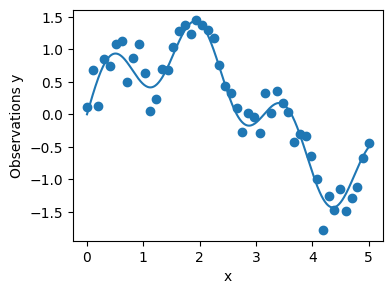

In [9]:
def data_maker1(x, sig):
    x = np.asarray(x)
    return np.sin(x) + 0.5 * np.sin(4 * x) + np.random.randn(*x.shape) * sig

sig = 0.25
train_x = np.linspace(0, 5, 50)
test_x = np.linspace(0, 5, 500)
train_y = data_maker1(train_x, sig=sig)
test_y = data_maker1(test_x, sig=0.0)

plt.scatter(train_x, train_y)
plt.plot(test_x, test_y)
plt.xlabel("x")
plt.ylabel("Observations y")
plt.show()


 Circles are noisy observations, the blue curve is the underlying noise‑free function.

 Prior GP samples

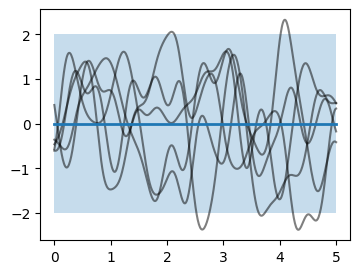

In [10]:
mean = np.zeros_like(test_x)
cov = rbf_kernel(test_x, test_x, ls=0.2)

prior_samples = np.random.multivariate_normal(mean=mean, cov=cov, size=5)
plt.plot(test_x, prior_samples.T, color="black", alpha=0.5)
plt.plot(test_x, mean, linewidth=2.)
std = np.sqrt(np.diag(cov))
plt.fill_between(test_x, mean - 2 * std, mean + 2 * std, alpha=0.25)
plt.show()


 Short length‑scale gives very wiggly sample functions.

 Hyperparameter learning (from scratch)

In [13]:
ell_est = 0.4
post_sig_est = 0.5

def neg_MLL(pars):
    ell, noise = pars
    K = rbf_kernel(train_x, train_x, ls=ell)
    Ky = K + noise**2 * np.eye(*train_x.shape)
    L = np.linalg.cholesky(Ky)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, train_y))
    kernel_term = -0.5 * train_y @ alpha
    logdet = -np.sum(np.log(np.diag(L)))
    const = -0.5 * train_x.shape[0] * np.log(2 * np.pi)
    return -(kernel_term + logdet + const)

res = optimize.minimize(
    neg_MLL,
    x0=np.array([ell_est, post_sig_est]),
    bounds=((0.01, 10.), (0.01, 10.))
)
ell, post_sig_est = res.x

print("Learned length‑scale:", ell)
print("Learned noise std:", post_sig_est)


Learned length‑scale: 0.5780687474139707
Learned noise std: 0.22470850523850983


 Now we compute the posterior mean and covariance at test points.

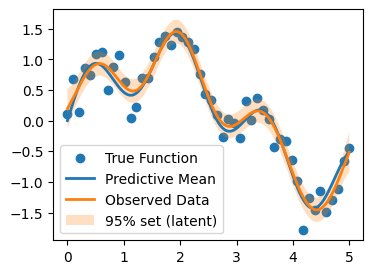

In [15]:
K_x_x = rbf_kernel(train_x, train_x, ls=ell)
K_x_xstar = rbf_kernel(train_x, test_x, ls=ell)
K_xstar_xstar = rbf_kernel(test_x, test_x, ls=ell)

Ky = K_x_x + post_sig_est**2 * np.eye(*train_x.shape)
L = np.linalg.cholesky(Ky)
alpha = np.linalg.solve(L.T, np.linalg.solve(L, train_y))

post_mean = K_x_xstar.T @ alpha
v = np.linalg.solve(L, K_x_xstar)
post_cov = K_xstar_xstar - v.T @ v

post_std = np.sqrt(np.diag(post_cov))
lw_bd = post_mean - 2 * post_std
up_bd = post_mean + 2 * post_std

plt.scatter(train_x, train_y)
plt.plot(test_x, test_y, linewidth=2.)
plt.plot(test_x, post_mean, linewidth=2.)
plt.fill_between(test_x, lw_bd, up_bd, alpha=0.25)
plt.legend(["True Function", "Predictive Mean", "Observed Data", "95% set (latent)"])
plt.show()


 The posterior mean closely follows the true function.

 The shaded band is a 95% credible set for the latent noise‑free function f(x).

 To include observation noise in the band, add σ² on the diagonal:

In [16]:
lw_bd_obs = post_mean - 2 * np.sqrt(post_std**2 + post_sig_est**2)
up_bd_obs = post_mean + 2 * np.sqrt(post_std**2 + post_sig_est**2)


 Posterior samples

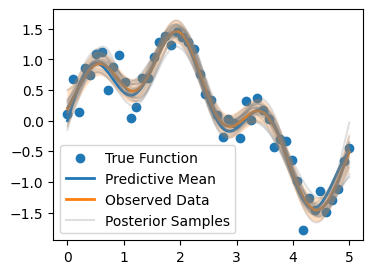

In [17]:
post_samples = np.random.multivariate_normal(post_mean, post_cov, size=20)
plt.scatter(train_x, train_y)
plt.plot(test_x, test_y, linewidth=2.)
plt.plot(test_x, post_mean, linewidth=2.)
plt.plot(test_x, post_samples.T, color="gray", alpha=0.25)
plt.fill_between(test_x, lw_bd, up_bd, alpha=0.25)
plt.legend(["True Function", "Predictive Mean", "Observed Data", "Posterior Samples"])
plt.show()


 Next we reproduce the same regression using GPyTorch.

 GPyTorch implementation

In [18]:
train_x_t = torch.tensor(train_x, dtype=torch.float32)
train_y_t = torch.tensor(train_y, dtype=torch.float32)
test_x_t = torch.tensor(test_x, dtype=torch.float32)
test_y_t = torch.tensor(test_y, dtype=torch.float32)

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x_t, train_y_t, likelihood)

training_iter = 50
model.train()
likelihood.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x_t)
    loss = -mll(output, train_y_t)
    loss.backward()
    if i % 10 == 0:
        print(
            f"Iter {i+1:d}/{training_iter:d} - Loss: {loss.item():.3f} "
            f"squared lengthscale: "
            f"{model.covar_module.base_kernel.lengthscale.item():.3f} "
            f"noise variance: {model.likelihood.noise.item():.3f}"
        )
    optimizer.step()


Iter 1/50 - Loss: 0.983 squared lengthscale: 0.693 noise variance: 0.693
Iter 11/50 - Loss: 0.695 squared lengthscale: 0.522 noise variance: 0.313
Iter 21/50 - Loss: 0.429 squared lengthscale: 0.549 noise variance: 0.127
Iter 31/50 - Loss: 0.304 squared lengthscale: 0.541 noise variance: 0.055
Iter 41/50 - Loss: 0.319 squared lengthscale: 0.545 noise variance: 0.038


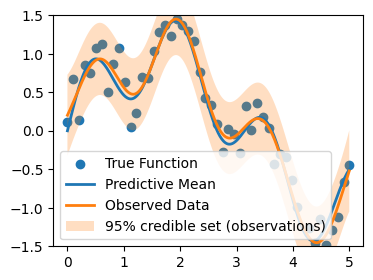

In [19]:
model.eval()
likelihood.eval()
with torch.no_grad():
    observed_pred = likelihood(model(test_x_t))
    lower, upper = observed_pred.confidence_region()
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax.scatter(train_x_t.numpy(), train_y_t.numpy())
    ax.plot(test_x_t.numpy(), test_y_t.numpy(), linewidth=2.)
    ax.plot(test_x_t.numpy(), observed_pred.mean.numpy(), linewidth=2.)
    ax.fill_between(test_x_t.numpy(), lower.numpy(), upper.numpy(), alpha=0.25)
    ax.set_ylim([-1.5, 1.5])
    ax.legend(["True Function", "Predictive Mean", "Observed Data",
               "95% credible set (observations)"])


 The GPyTorch model recovers almost the same fit.

 Here the band is a 95% credible set for noisy observations (latent plus noise).